In [1]:
import numpy as np
import pandas as pd
import doubleml as dml
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
df=pd.read_csv(r"C:\Users\jortk\OneDrive\OneDrive Documenten\ENSAE\ENSAE ML for Econometrics\Project\data.csv", sep=";")

# Standardize column names (fix spacing issues)
df.columns = df.columns.str.strip().str.replace(" ", "_").str.lower()

# Convert Target Variable to Binary (Dropout = 1, Others = 0)
df["binary_target"] = df["target"].apply(lambda x: 1 if x == 'Dropout' else 0)

# Define Treatment & Outcome Variables
treatment = "scholarship_holder"  # Binary treatment variable
outcome = "binary_target"  # Outcome variable

# Your chosen covariates
covariates = [
    "application_order", "daytime/evening_attendance", "previous_qualification_(grade)",
    "admission_grade", "displaced", "educational_special_needs", "gender",
    "age_at_enrollment", "international", "unemployment_rate", "inflation_rate", "gdp"
]

# Drop missing values
df = df.dropna(subset=[treatment, outcome] + covariates)

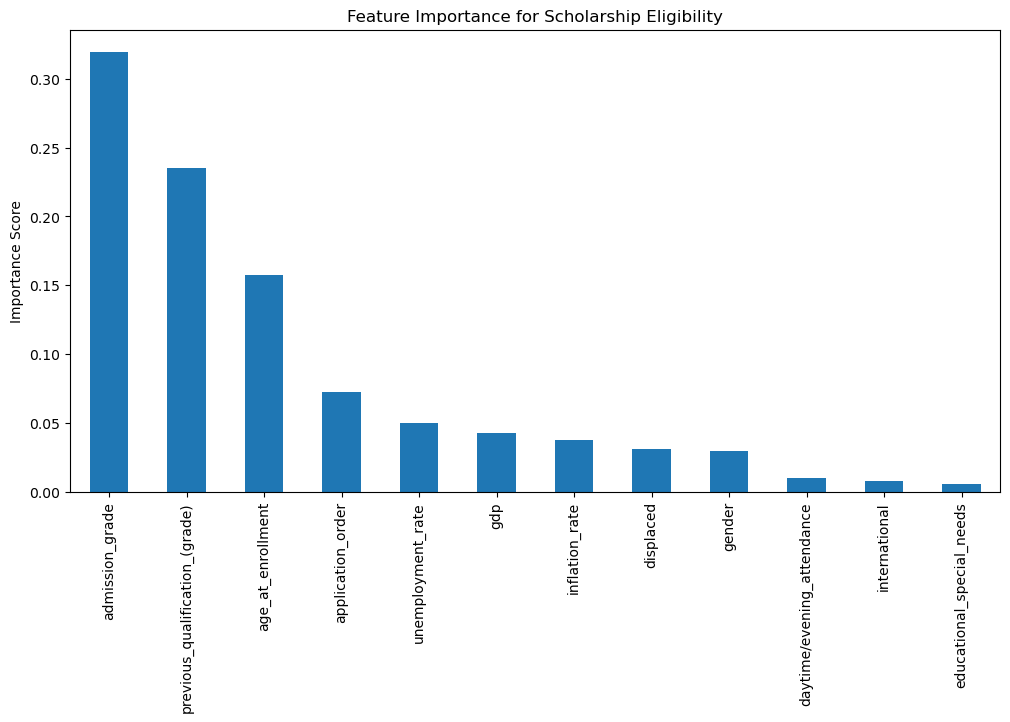

In [2]:
# Train Random Forest to see which features matter for Scholarships
ml_m = RandomForestClassifier(n_estimators=100, random_state=42)
ml_m.fit(df[covariates], df['scholarship_holder'])

# Extract Feature Importance
feature_importance = pd.Series(ml_m.feature_importances_, index=covariates).sort_values(ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
feature_importance.plot(kind='bar', title="Feature Importance for Scholarship Eligibility")
plt.ylabel("Importance Score")
plt.show()

In [3]:
# Define Features (X), Treatment (T), and Outcome (Y)
X = df[covariates]
T = df[treatment]
Y = df[outcome]

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define DML dataset (No train-test split, using all data)
dml_data = dml.DoubleMLData.from_arrays(X_scaled, Y, T)

# Define ML models for treatment & outcome
ml_m = RandomForestClassifier(n_estimators=500, random_state=42)  # Treatment model
ml_l = LassoCV(cv=5)  # Outcome model

# Fit Double Machine Learning Model
dml_model = dml.DoubleMLPLR(dml_data, ml_l, ml_m)
dml_model.fit()
print(dml_model.summary)
# Print causal effect
print(f"Estimated Treatment Effect: {dml_model.coef}")
print(f"Standard Error: {dml_model.se}")


       coef   std err        t         P>|t|     2.5 %    97.5 %
d -0.166158  0.013363 -12.4341  1.706513e-35 -0.192349 -0.139967
Estimated Treatment Effect: [-0.1661577]
Standard Error: [0.01336307]


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [4]:
# Extract estimated treatment effect & standard error
treatment_effect = dml_model.coef[0]
standard_error = dml_model.se[0]

# Compute 95% Confidence Interval
lower_bound = treatment_effect - 1.96 * standard_error
upper_bound = treatment_effect + 1.96 * standard_error

# Print Results
print(f"Estimated Treatment Effect: {treatment_effect:.4f}")
print(f"Standard Error: {standard_error:.4f}")
print(f"95% Confidence Interval: [{lower_bound:.4f}, {upper_bound:.4f}]")

# Check significance using p-value
import scipy.stats as stats

t_stat = treatment_effect / standard_error
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))  # Two-tailed test

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The treatment effect is statistically significant at the 5% level.")
else:
    print("❌ The treatment effect is NOT statistically significant.")


Estimated Treatment Effect: -0.1662
Standard Error: 0.0134
95% Confidence Interval: [-0.1923, -0.1400]
T-statistic: -12.4341
P-value: 0.0000
✅ The treatment effect is statistically significant at the 5% level.


In [5]:
# Split data into male and female groups
df_male = df[df["gender"] == 0]
df_female = df[df["gender"] == 1]

def run_dml_analysis(subset_df):
    X_sub = subset_df[covariates]
    T_sub = subset_df[treatment]
    Y_sub = subset_df["binary_target"]
    
    # Standardize
    X_sub_scaled = scaler.fit_transform(X_sub)

    # Set up DML
    dml_data_sub = dml.DoubleMLData.from_arrays(X_sub_scaled, Y_sub, T_sub)
    dml_model_sub = dml.DoubleMLPLR(dml_data_sub, ml_l, ml_m)
    dml_model_sub.fit()

    return dml_model_sub.coef[0], dml_model_sub.se[0]

# Run for each gender
effect_male, se_male = run_dml_analysis(df_male)
effect_female, se_female = run_dml_analysis(df_female)

print(f"Treatment Effect (Males): {effect_male:.4f} ± {se_male:.4f}")
print(f"Treatment Effect (Females): {effect_female:.4f} ± {se_female:.4f}")


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


Treatment Effect (Males): -0.1566 ± 0.0149
Treatment Effect (Females): -0.2094 ± 0.0293


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'


In [6]:
# Replace Lasso with Ridge
ml_l_ridge = RidgeCV(alphas=[0.1, 1.0, 10.0])

# Run DML with Ridge
dml_model_ridge = dml.DoubleMLPLR(dml_data, ml_l_ridge, ml_m)
dml_model_ridge.fit()

# Print results
print(f"Estimated Treatment Effect (Ridge): {dml_model_ridge.coef}")
print(f"Standard Error (Ridge): {dml_model_ridge.se}")

Estimated Treatment Effect (Ridge): [-0.17019928]
Standard Error (Ridge): [0.0134367]


C:\Users\jortk\anaconda3\Lib\site-packages\doubleml\utils\_checks.py:205: UserWarning: Propensity predictions from learner RandomForestClassifier(n_estimators=500, random_state=42) for ml_m are close to zero or one (eps=1e-12).
  warnings.warn(f'Propensity predictions from learner {str(learner)} for'
